In [1]:
# Import finance API and get historical stock data
import yfinance as yf # a package that lets you download stock prices
msft = yf.Ticker("MSFT") # to use this package, we have to create a ticker object
msft_hist = msft.history(period="max") # download the whole full price history of microsoft by specifying "Peiod = max"

In [2]:
# Explore the stock history by looking at the first 5 postings
msft_hist.head(5)

# Shows that microsoft first started trading in 1986 and it was about 5 cents that first day

# Open - The price of the stock of which it opened on that day
# High - The highest price during the day
# Low - The lowest price during the day
# Close - The closing price at the end of the day 
# Volume - The number of shares that were bought and sold during the day

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,0.0,0.0
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,0.0,0.0
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,0.0,0.0
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,0.0,0.0
1986-03-19,0.062892,0.063439,0.061252,0.061799,47894400,0.0,0.0


In [3]:
# Checking for null values 

msft_hist.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

<AxesSubplot:xlabel='Date'>

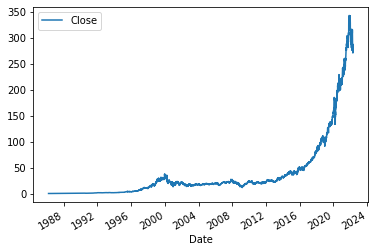

In [4]:
# Visualize microsoft stock prices. Index is all of the dates
msft_hist.plot.line(y="Close", use_index=True)

In [5]:
# Prepare the data for machine learning 

# First thing to do, is to set up the data with our target
# Our target is for us to find out whether stock price will go up or down tomorrow  

# what rolling does, is it goes across the data frame. 
# in this instance, it will look at first 2 rows, then the next 2, and so on...
# what we can say is.. if the second row is higher than the first row, return 1, otherwise return 0. 

# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {"Close":"Actual_Close"})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Checking to see if there is a class imbalance issue. 
# Classes are evenly distributed for the most part (i.e. days where the price went up vs went down are evenly distributed)
data["Target"].value_counts()

1.0    4604
0.0    4501
Name: Target, dtype: int64

In [6]:
data.head(5)

,Actual_Close,Target
Date,,
1986-03-13,0.061252,NaN
1986-03-14,0.063439,1.0
1986-03-17,0.064533,1.0
1986-03-18,0.062892,0.0
1986-03-19,0.061799,0.0


In [7]:
# it is 1.0 when the closing price was higher than the day before and 0.0 otherise.

In [8]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)
msft_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055783,0.063987,0.055783,0.061252,1.031789e+09,0.0,0.0
1986-03-17,0.061252,0.064533,0.061252,0.063439,3.081600e+08,0.0,0.0
1986-03-18,0.063439,0.065080,0.063439,0.064533,1.331712e+08,0.0,0.0
1986-03-19,0.064533,0.065080,0.062345,0.062892,6.776640e+07,0.0,0.0


In [9]:
# Create our training data

# Set up our predictors
# Predictors are the columns we want to use to make our predictions
# These are the columns we are going to use to predict our target

predictors = ["Close", "Volume", "Open", "High", "Low"]

# Join those columns (aka "predictors") with the target (aka "data")
data = data.join(msft_prev[predictors]).iloc[1:]
# .iloc[1:] means we are only going to take row 1 and forwared becasue
# there is no row before the first day microsoft was traded on.

data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14,0.063439,1.0,0.061252,1.031789e+09,0.055783,0.063987,0.055783
1986-03-17,0.064533,1.0,0.063439,3.081600e+08,0.061252,0.064533,0.061252
1986-03-18,0.062892,0.0,0.064533,1.331712e+08,0.063439,0.065080,0.063439
1986-03-19,0.061799,0.0,0.062892,6.776640e+07,0.064533,0.065080,0.062345
1986-03-20,0.060158,0.0,0.061799,4.789440e+07,0.062892,0.063439,0.061252


In [10]:
# Training the Machine Learning Model 

In [11]:
# use the library called scikit-learn

# this package has most common machine learning algorithms already implemented 

!pip install scikit-learn

In [12]:
# We will be using a Classification Machine Learning Model

# we are going to import a model from scikit-learn which is called random forest classifier 
# this is an algorithm consisting of many decisions tress. 

# Random forest classifier is a good "default" model for a lot of applications
# because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

# We are going to use a classification model instead of a regression model because our target is binary. 
# The target is a 0 or 1 - meaning that stock price will either go up or down. 

from sklearn.ensemble import RandomForestClassifier
import numpy as np 

# Initialize the model and set parameters.
# Paramaters allow us to set various past steps taken in the model

## n_estimators=100 indicates how many individual deceision trees we want to train. 
# this means we want to train a 100 decision trees, and average their results to get our final result

# random forest and decision trees can easily overfit the data.
## min_samples_split, it prevents tree from fitting itself as tightly to the data. 
# The less tightly you're fitting, the better you can generalize to future data and the less you are going to overfit 
# So, model overfitting means the model performs really well on the training data, but really poorly on the test data and in the real world
# We want our model to perform well in the real world, so we are avoiding fitting too tightly to the training data. 

## random_state - everytime you run the alogorithm, it will give you constant results. 

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set

#taking the whole dataset except the last 100 rows
train = data.iloc[:-100]

#Predict the last 100 rows 
test = data.iloc[-100:]

# Something important when making predictions on the stock market data, is to keep the order of the data in mind. 
# So typically to evaluate error of your machine learning model, you are going to use cross validation. 
# The problem with cross validation here, is if you split the data up, sometimes cross validation used the later parts of the data 
# to predict the earlier parts. But here, you can't use data from 2020 to predict data that happned in 2019.
# That is not realistic and is not going match the real world. You would get a model that looks awesome in training, 
# but would not be accurate for real life. 

# fit the model on our training dataset with our predictors. We are trying to fit it to the target. 
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [13]:
# Now we need to see how accurate our model was 

In [14]:
# scikit-learn has a function called "precision score" which calculates precision
# It is identifying how many 'true positives' which only takes account of days the algorithm said 
# algorithm teh price would go up, and it actually did go up. Divided by every time the algorithm 
# the predicted the price to go up, regardless if it did or not. 

# we'll be using precision as our error metric for our algorithm, which is true positives / (false positives + true positives). 
# This will ensure that we minimize how much money we lose with false positives (days when we buy the stock, but the price actually goes down).
# This is so we dont buy the stock thinking the price will go up the next day, but it actually goes down from where we bought it at and then we lose money. 


# this is the percentage of days where the alogrithm said the price would go up, and it actually did
from sklearn.metrics import precision_score

In [15]:
# Evaluate error of predictions. Now we can generage our predictions. 

# on the test set - which is just the last 100 rows of the data, these would be our predictions from the model
preds = model.predict(test[predictors])
preds 

array([1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.])

In [16]:
# we can put these predictions into a pandas series. To calculate error, we need to look at our real values vs. our predicted values
# turn these predictions into a pandas series which puts the dates (index) side-by-side with the predictions
import pandas as pd

preds = pd.Series(preds, index=test.index)
preds

Date
2021-12-03    1.0
2021-12-06    1.0
2021-12-07    1.0
2021-12-08    1.0
2021-12-09    1.0
             ... 
2022-04-21    0.0
2022-04-22    1.0
2022-04-25    1.0
2022-04-26    1.0
2022-04-27    1.0
Length: 100, dtype: float64

In [17]:
# Evaluate error of predictions
precision_score(test["Target"], preds)

# So our model is directionally accurate only 47% of the time.

0.4823529411764706

In [18]:
# combining our predictions with our actual target (whis is what really occured).
# Target - actual values 
# Predictions - what the algorithm predicted 

combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined

,Target,Predictions
Date,,
2021-12-03,0.0,1.0
2021-12-06,1.0,1.0
2021-12-07,1.0,1.0
2021-12-08,1.0,1.0
2021-12-09,0.0,1.0
...,...,...
2022-04-21,0.0,0.0
2022-04-22,0.0,1.0
2022-04-25,1.0,1.0


<AxesSubplot:xlabel='Date'>

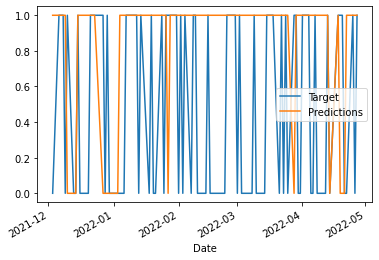

In [19]:
# plot what the algorithm predicted vs what really happened 
combined.plot()

In [20]:
# Creating a Backtesting Engine 
# What backtesting does is getting us from only predicting 100 rows, to predicting most of the dataset. 
# This will give us a really robust error metric. 

# we want an error metric that is representative of the enire dataset, because then we can be confident that it can be applied into the future.
# Versus a small sample of the data. 

# backtesting involves looping over the data, splitting the data up, then training a model ever so often and using it to predict the next few row. 
# For example, we might take the first 1,000 rows, use that the predict the next 1,000 rows. 
# Then take the first next 2,000 rows, use that to predict the next 1,000 rows and so on.. until we predict the whole dataset. 

#Backtesting Loop
# we start at row 1000
# then were going to train the model on data from row 0 to row 1000
# Then were going to make predictions from row 1000 to row 1750 and so on..

# This is looping over our entire dataset - starting at row 1,000
# Making predictions evey 750 rows for the next 750 rows 


def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [21]:
predictions = backtest(data, model, predictors)

In [22]:
# On 7,433 days we predicted the price to go down 
# On 670 days we predicted the price to go up 

# There are not a lot of days that we are preidicting to go up becasue we set the 
# threshold at 60%. 

# Although we are predicting less days, the hope is to predict with accuracy.
# we are tyring to maximize our precision

predictions["Predictions"].value_counts()

0.0    7354
1.0     751
Name: Predictions, dtype: int64

In [23]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4993342210386152

In [24]:
# Currently our precision score is 49%.
# This means that whenver we predict the price to go up, there is only a 49% chance that the prediction is accurate

In [25]:
# How can we improve our accuracy? By adding more predictors 

# Provide the algorithm with some ratios

# between what the weekly average price is and the closing price
# between what the quarterly average price is and the closing price
# between what annual average price is and the close price
# we can look the weekly trend to see in the past 7 days, on average what was the percentage chance that the price would go up

weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [26]:
#assign these ratios to different columns in our dataframe 

# average weekly price / daily closing price 
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
# average quarterly price / daily closing price 
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
# average annual price / daily closing price 
data["annual_mean"] = annual_mean["Close"] / data["Close"]


data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

#this helps the algorithm understand trends 
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [27]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", 
                                "annual_weekly_mean", "annual_quarterly_mean", 
                                "open_close_ratio", "high_close_ratio", "low_close_ratio", 
                                "weekly_trend"]

predictions = backtest(data.iloc[365:], model, full_predictors)

In [28]:
# Show how many trades we would make. We'd be trading on fewer days, however
# our algorithm will be making more accurate predictions

predictions["Predictions"].value_counts()

0.0    7537
1.0     203
Name: Predictions, dtype: int64

In [29]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6059113300492611

<AxesSubplot:xlabel='Date'>

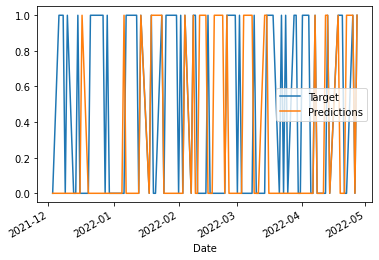

In [30]:
predictions.iloc[-100:].plot()

In [31]:
predictions

,Target,Predictions
Date,,
1991-08-07,1.0,0.0
1991-08-08,1.0,0.0
1991-08-09,1.0,0.0
1991-08-12,1.0,0.0
1991-08-13,0.0,0.0
...,...,...
2022-04-21,0.0,0.0
2022-04-22,0.0,1.0
2022-04-25,1.0,1.0
